In [6]:
#%matplotlib notebook
import glob
import io
import os
import cv2
from svglib.svglib import svg2rlg
from collections import defaultdict
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import numpy as np
#import matplotlib; matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

In [7]:
def parse_CVC_FP_svg(path, classes):
    """Parser for SVGs form the CVC-FP dataset:
        http://dag.cvc.uab.es/resources/floorplans/
    """
    drawing = svg2rlg(path)
    byclass = defaultdict(list)
    for cls in classes:
        for py in drawing.contents[0].contents:
            if py._class == cls:
                loop = list(zip(py.points[::2], py.points[1::2]))
                byclass[py._class].append(loop)
    return byclass, drawing.height, drawing.width

In [15]:
df = gpd.read_file('boston_buildings/boston_buildings.shp')

In [16]:
df.head()

,BUILDING_I,PARCEL_ID,ADDRESS_ID,PART_ADDRE,PART_ID,PART_USE,PART_BRA_U,PART_CONTA,PART_STATU,PART_VIEW,...,BUILDING_H,IEL_TYPE,BASE_ELEVA,ELEVATION_,TOP_SEA_LE,ELEVATION1,TOP_GROUND,Shape_area,Shape_len,geometry
0,Bos_2205632000_B0,2205632000,2205632000_A0,"68 KENRICK ST, 02135",Bos_2205632000_B0_M0,R1,R1,MCNAMARA ROBERT O,BUILT,PUBLIC,...,16.890698,BLDG,55.365665,70.138047,74.846878,14.772382,19.481212,1161.397293,149.394841,"POLYGON Z ((746591.271 2951419.399 69.207, 746..."
1,Bos_2102861000_B1,2102861000,2102861000_A0,"53 CHESTNUT HILL AV, 02135",Bos_2102861000_B1_M0,R2,R2,CUNNINGHAM JOHN J,BUILT,PUBLIC,...,36.756003,BLDG,129.925217,137.779148,146.070301,7.853931,16.145084,549.002100,96.663101,"POLYGON Z ((749810.012 2951406.252 137.778, 74..."
2,Bos_2204921000_B0,2204921000,2204921000_A0,"97 ACADEMY HILL RD, 02135",Bos_2204921000_B0_M0,R2,R2,KEEFE EDWARD J,BUILT,PUBLIC,...,21.713000,BLDG,162.142441,184.654210,190.966186,22.511769,28.823745,1456.043245,181.859296,"POLYGON Z ((749458.573 2951325.510 175.721, 74..."
3,Bos_2102862000_B1,2102862000,2102862000_A0,"55 CHESTNUT HILL AV, 02135",Bos_2102862000_B1_M0,R3,R3,CUNNINGHAM JOHN J,BUILT,PUBLIC,...,22.761005,BLDG,131.035858,152.578506,161.123235,21.542647,30.087377,982.054372,135.393057,"POLYGON Z ((749791.436 2951364.987 144.628, 74..."
4,Bos_2102870000_B0,2102870000,2102870000_A0,"15 WM JACKSON AV, 02135",Bos_2102870000_B0_M0,R1,R1,YUNG JIN P,BUILT,PUBLIC,...,20.348997,BLDG,170.059418,184.541181,196.525357,14.481763,26.465939,1167.143115,149.400957,"POLYGON Z ((749737.548 2951033.339 183.535, 74..."


In [2]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

def parse_parcel(py):
    if isinstance(py, Polygon):
        bound = list(zip(*py.exterior.coords.xy))
        holes = [list(zip(*hole.coords.xy)) for hole in py.interiors]
        #return bound, holes
        return [bound]
    elif isinstance(py, MultiPolygon):
        parts = [parse_parcel(part) for part in py.geoms]
        return [x for y in parts for x in y]
    else:
        print('bad shape type:', type(py))

def parse_building(py):
    return parse_parcel(py)
    
def bbox(pts):
    x, y = pts[0]
    ax, ay, bx, by = x, y, x, y
    for i in range(1, len(pts)):
        x, y = pts[i]
        ax = x if x < ax else ax
        ay = y if y < ay else ay
        bx = x if x > bx else bx
        by = y if y > by else by
    return ax, ay, bx, by
    
def parse_bostonbuildings_shps(path='./boston_buildings/'):
    parcels_df = gpd.read_file('boston_buildings/Parcels_2018.shp')
    parcels = parcels_df.geometry.apply(parse_parcel)
    buildings_df = gpd.read_file('boston_buildings/Boston_Buildings.shp')
    buildings = buildings_df.geometry.apply(parse_building)
    
    samples = []
    for parcel in filter(None, parcels):
        pts = [p for bnd in parcel for p in bnd]
        ax, ay, bx, by = bbox(pts)
        h, w = (by - ay), (bx - ax)
        parcel = [[(x - ax, y - ay) for x, y in part] for part in parcel]
        byclass = {'parcel': parcel} #, 'footprints': buildings}
        samples.append((byclass, h, w))

    return samples
    #return buildings_df, parcels_df, byclass

#buildings_df, parcels_df, byclass = parse_bostonbuildings_shps()
parsed_boston = parse_bostonbuildings_shps()

bad shape type: <class 'NoneType'>
bad shape type: <class 'NoneType'>


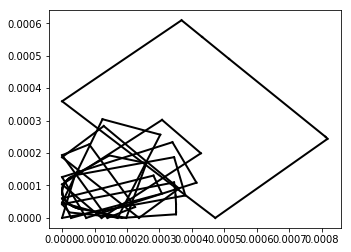

In [14]:
f, ax = plt.subplots()
ax.set_aspect(1)
l = Layer()
for byclass, h, w in parsed_boston[:10]:
    for parcel in byclass['parcel']:
        l.plot_loop(ax, parcel)

In [4]:
parsed_boston[0]

({'parcel': [[(0.00030252900000959926, 0.0002564780000398059),
    (0.0001711599999794089, 0.0),
    (5.553900001586953e-05, 3.163700000641256e-05),
    (0.0, 4.6932000032029464e-05),
    (0.00012447300002804695, 0.0003041190000203642),
    (0.00030252900000959926, 0.0002564780000398059)]]},
 0.0003041190000203642,
 0.00030252900000959926)

In [7]:
parcels_df.head()

,FID,WARD,PARCEL,PID_LONG,WPD,BATCH,SHAPE_Leng,SHAPE_Area,geometry
0,1,12.0,2742,1202742000,12-06-005,NaN,0.000936,5.089961e-08,"POLYGON ((-71.08039 42.31335, -71.08053 42.313..."
1,2,16.0,934,1600934000,16-01-060,NaN,0.000957,4.260230e-08,"POLYGON ((-71.06130 42.29597, -71.06100 42.296..."
2,3,16.0,2862,1602862000,16-06-020,NaN,0.000707,1.818355e-08,"POLYGON ((-71.05877 42.28976, -71.05905 42.289..."
3,4,20.0,8008,2008008000,20-17-140,NaN,0.000917,4.575228e-08,"POLYGON ((-71.16790 42.28730, -71.16802 42.287..."
4,5,14.0,1192,1401192000,14-04-085,NaN,0.002041,2.432359e-07,"POLYGON ((-71.07614 42.30157, -71.07649 42.301..."


In [6]:
buildings_df.head()

,OBJECTID,BLDG_ID,BID,LIFECYCLE_,TYPE_ID,LIFECYCL_1,Shapearea,Shapelen,geometry
0,94426,Bos_1103442000_B0,97592.0,1.0,NaN,None,1539.963997,162.628625,"POLYGON ((-71.11928 42.30488, -71.11928 42.304..."
1,94428,Bos_1103444000_B0,97594.0,1.0,NaN,None,1607.626356,173.981004,"POLYGON ((-71.11932 42.30514, -71.11930 42.305..."
2,94435,Bos_1103469000_B0,97601.0,1.0,NaN,None,1283.085419,166.904408,"POLYGON ((-71.11901 42.30615, -71.11901 42.306..."
3,94437,Bos_1103502000_B0,97603.0,1.0,NaN,None,1114.696267,156.375121,"POLYGON ((-71.11894 42.30592, -71.11904 42.305..."
4,94442,Bos_1804492000_B0,97608.0,1.0,NaN,None,1024.556178,153.921572,"POLYGON ((-71.12872 42.28453, -71.12871 42.284..."


In [10]:
class Layer:
    """Container-like class for representing either an
    input or output image directory for training a pix2pix model"""

    @staticmethod
    def save_image(path, image, cmap='gist_earth_r'):
        """Plot/save an image at a path via matplotlib"""
        n_cols = n_rows = 1
        n_pixels = 256
        dpi_of_monitor = 96 # HARDCODED DPI VALUE FROM MY OLD DELL LAPTOP...
        figsize = (n_pixels * n_cols / dpi_of_monitor,
                   n_pixels * n_rows / dpi_of_monitor)
        f, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
        f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
        ax.axis('off')
        ax.imshow(image, cmap=cmap, vmin=0, vmax=None)
        f.savefig(path, dpi=dpi_of_monitor)
        plt.close(f)
    
    @classmethod
    def svgs_to_imgs(cls, parsed_svgs, directory=None, show_instead=False):
        """Create folder of images for image-translation from a list of SVG paths"""
        layer = cls()
        directory = os.getcwd() if directory is None else directory
        directory = os.path.join(directory, layer.name)
        os.makedirs(directory, exist_ok=True)
        for svg, (byclass, height, width) in tqdm(parsed_svgs.items(), desc=layer.name):
            filename = os.path.basename(svg)
            path = os.path.join(directory, filename[:filename.rfind('.')])
            image = layer(byclass, height, width)
            if show_instead:
                layer.show(layer=image)
            else:
                layer.save_image(path, image)
    
    def plot_loop(self, ax, loop, lw=2, ls='-', col='k', fill=None):
        """Plot the polygon `loop`"""
        if fill is not None:
            xs, ys = zip(*loop)
            ax.fill(xs, ys, fill)
        for i in range(len(loop)):
            (ux, uy), (vx, vy) = loop[i - 1], loop[i]
            ax.plot([ux, vx], [uy, vy], lw=lw, ls=ls, color=col)

    def show_style(self, ax, style, byclass):
        """Plot the data in `byclass` based on specification in `style`"""
        ax.axis('off')
        ax.set_aspect(1)
        for cls in byclass:
            col, ls = style[cls]
            for part in byclass[cls]:
                self.plot_loop(ax, part, lw=2, ls=ls, col=col, fill=col)

    def figure_buffer(self, fig, dpi=180):
        """Create np.array representation from matplotlib figure buffer"""
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=dpi)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def mask(self, byclass, height, width, figsize=(10, 10), dpi=180):
        """Create a mask to find the boundary of the sample"""
        # make ~binary mask using available classes
        style = {cls: ('k', '-') for cls in byclass}
        fig = Figure(figsize=figsize)
        fig.tight_layout(pad=0)
        fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
        canvas = FigureCanvas(fig)
        ax = fig.subplots(1, 1)
        self.show_style(ax, style, byclass)
        ax.set_xlim(0, height)
        ax.set_ylim(0, width)
        canvas.draw()
        mask = self.figure_buffer(fig, dpi=dpi)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # fill in the gaps via:
        # https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
        _, thresholded = cv2.threshold(mask, 220, 255, cv2.THRESH_BINARY_INV);
        floodfilled = thresholded.copy()
        h, w = thresholded.shape[:2]
        mask = np.zeros((h + 2, w + 2), np.uint8)
        cv2.floodFill(floodfilled, mask, (0, 0), 255);
        mask = cv2.bitwise_not(thresholded | cv2.bitwise_not(floodfilled))
        return mask
    
    def norm_mask(self, mask):
        """Renormalize mask by the current label set maximum"""
        lmax = max(self.labels.values())
        return (mask * (lmax / mask.max())).astype(int)
        
    def show(self, byclass=None, height=None, width=None, layer=None,
             ax=None, figsize=(10, 10), cmap='gist_earth_r'):
        if ax is None:
            f, ax = plt.subplots(figsize=figsize)
        if layer is None:
            layer = self(byclass, height, width)
        ax.imshow(layer, cmap=cmap)
        return ax
    
    labels = {'Void': 0}
    
    def __init__(self, labels=None, name=None):
        self.labels = self.__class__.labels if labels is None else labels
        self.name = self.__class__.__name__ if name is None else name

    def __call__(self, byclass, height, width):
        """Create the layer as an image (subclasses must override)
        
        Args:
            byclass (dict): Polygon data organized by class label
            height (int): Upper limit for x-axis of image
            width (int): Upper limit for y-axis of image
            
        Returns:
            np.array image representation of the layer
        
        """
        raise NotImplementedError
    

class FootprintInputLayer(Layer):
    
    labels = dict([
        ('Footprint', 5),
    ])

    def __call__(self, byclass, height, width):
        mask = self.norm_mask(self.mask(byclass, height, width))
        layer = mask.max() - mask
        return layer

        
class RepartitionInputLayer(Layer):
    
    labels = dict([
        ('Door', 1),
        ('Window', 2),
        ('Parking', 3),
        ('Room', 5),
    ])

    def __call__(self, byclass, height, width):
        # start with the inverse of the mask
        # blend in annotations which touch the boundary of the footprint
        mask = self.norm_mask(self.mask(byclass, height, width))
        layer = mask.max() - mask
        for cls, label in self.labels.items():
            for py in byclass[cls]:
                # determine if a dilated mask of py intersects the mask
                # which implies its a feature on the boundary of the footprint
                pymask = self.mask({cls: [py]}, height, width)
                kernel = np.ones((3, 3), np.uint8) 
                pyfilt = cv2.erode(pymask.copy(), kernel, iterations=1)
                pyfilt = (((mask) * (pyfilt.max() - pyfilt)).max() > 0)
                if pyfilt or cls == 'Room':
                    weight = (pymask == 0).astype(int)
                    layer = weight * label + (1 - weight) * layer
        return layer


class RepartitionOutputLayer(Layer):
    
    labels = dict([
        ('Door', 1),
        ('Window', 2),
        ('Parking', 3),
        ('Room', 4),
        ('Wall', 5),
    ])

    def __call__(self, byclass, height, width):
        mask = self.norm_mask(self.mask(byclass, height, width))
        layer = mask.max() - mask
        # start with the inverse of the mask
        # blend in annotations which touch the boundary of the footprint
        for cls, label in self.labels.items():
            for py in byclass[cls]:
                # determine if a dilated mask of py intersects the mask
                # which implies its a feature on the boundary of the footprint
                pymask = self.mask({cls: [py]}, height, width)
                kernel = np.ones((3, 3), np.uint8) 
                pymask = cv2.erode(pymask, kernel, iterations=3)
                # blend a mask of py with the layer using a binary weight
                weight = (pymask == 0).astype(int)
                layer = weight * label + (1 - weight) * layer
        return layer

In [4]:
svgs = glob.glob('ImagesGT/*.svg')
classes = (
    'Door',
    'Window',
    'Room',
    'Wall',
    'Separation',
    'Parking',
)
parsed = {svg: parse_CVC_FP_svg(svg, classes) for svg in svgs[:3]}

directory = './tmp3/'

FootprintInputLayer.svgs_to_imgs(parsed, directory)
RepartitionInputLayer.svgs_to_imgs(parsed, directory)
RepartitionOutputLayer.svgs_to_imgs(parsed, directory)

/home/cogle/dev/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


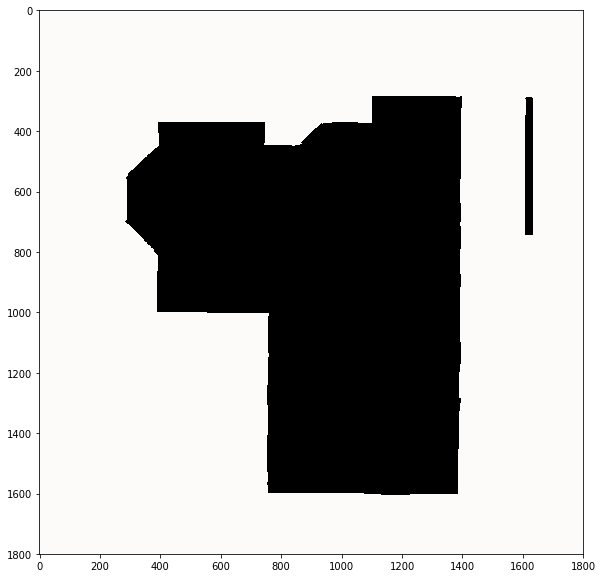

In [29]:
FootprintInputLayer().show(*tuple(parsed.values())[0])

In [2]:
# TODO:
#  remove meshmaker dependency
#  output any lineup to any folder; use combine_AB script from pix2pix

def plot_loop(ax, loop, lw=2, ls='-', col='k', fill=None):
    if fill is not None:
        xs, ys = zip(*loop)
        ax.fill(xs, ys, fill)
    for i in range(len(loop)):
        (ux, uy), (vx, vy) = loop[i - 1], loop[i]
        ax.plot([ux, vx], [uy, vy], lw=lw, ls=ls, color=col)

def show_style(ax, style, byclass):
    ax.axis('off')
    ax.set_aspect(1)
    for cls in byclass:
        col, ls = style[cls]
        for part in byclass[cls]:
            plot_loop(ax, part, lw=2, ls=ls, col=col, fill=col)

def figure_buffer(fig, dpi=180):
    # returns an image as numpy array from figure
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def fill_mask(im_in):
    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.
    th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
    # Copy the thresholded image.
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    return cv2.bitwise_not(im_out)

def get_mask(byclass, height, width, figsize=(10, 10), dpi=180):
    style = {cls: ('k', '-') for cls in byclass}
    fig = Figure(figsize=figsize)
    fig.tight_layout(pad=0)
    fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
    canvas = FigureCanvas(fig)
    ax = fig.subplots(1, 1)
    show_style(ax, style, byclass)
    d = 0
    ax.set_xlim(-d, height + d)
    ax.set_ylim(-d, width  + d)
    canvas.draw()
    mask = figure_buffer(fig, dpi=dpi)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = fill_mask(mask)
    return mask

def get_layer(mask, byclass, height, width, lineup, isleft):
    layer = mask.max() - mask
    for cls, label in lineup:
        for py in byclass[cls]:
            repack = {cls: Loops([py]).offset(-20).loops}
            pymask = get_mask(repack, height, width)
            pyfilt = (((mask) * (pymask.max() - pymask)).max() > 0)
            if not isleft or (pyfilt or cls == 'Room' or cls == 'Wall'):
                repack = {cls: [py]}
                remask = get_mask(repack, height, width)
                weight = (remask == 0).astype(int)
                layer = ((weight) * (label) + (1 - weight) * (layer))
    return layer


CLASSES = (
    'Door',
    'Window',
    'Room',
    'Wall',
    'Separation',
    'Parking',
)
leftlineup = (
    ('Door', 1),
    ('Window', 2),
    ('Parking', 3),
    ('Room', 5),
)
rightlineup = (
    ('Door', 1),
    ('Window', 2),
    ('Parking', 3),
    ('Room', 4),
    ('Wall', 5),
)

def save_sample(svg, classes=CLASSES, path='./tmp2/{}.png', cmap='gist_earth_r'):
    byclass, height, width = parse_svg(svg, classes)
    mask = get_mask(byclass, height, width)
    mask = (mask * (5 / mask.max())).astype(int)
    left  = get_layer(mask, byclass, height, width, leftlineup, True)
    right = get_layer(mask, byclass, height, width, rightlineup, False)

    dpi_of_monitor = 96
    figsize = (512 / dpi_of_monitor, 256 / dpi_of_monitor)
    #f, (left_ax, right_ax) = plot(1, 2, figsize)
    f, (left_ax, right_ax) = plt.subplots(1, 2, figsize=figsize)
    f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    left_ax.axis('off')
    right_ax.axis('off')
    left_ax.imshow(left, cmap=cmap, vmin=0, vmax=None)
    right_ax.imshow(right, cmap=cmap, vmin=0, vmax=None)
    
    fn = os.path.basename(svg)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    f.savefig(path.format(fn[:fn.rfind('.')]), dpi=dpi_of_monitor)

/home/cogle/dev/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


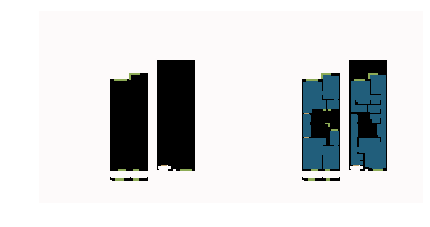

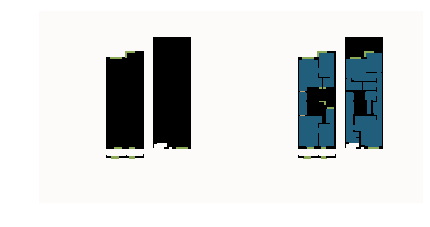

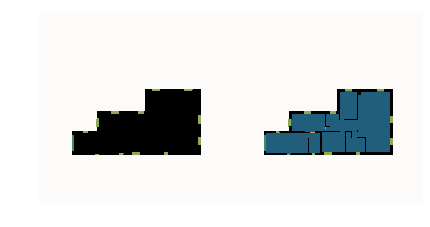

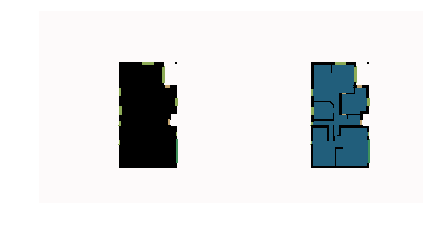

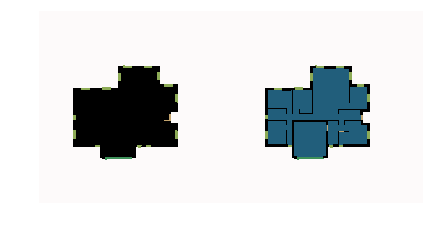

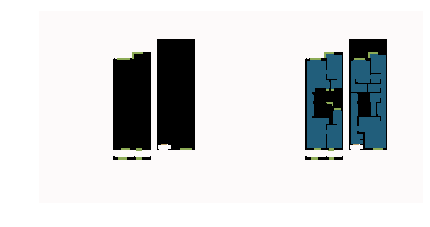

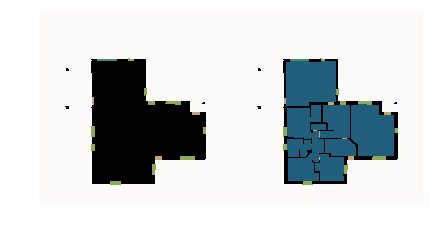

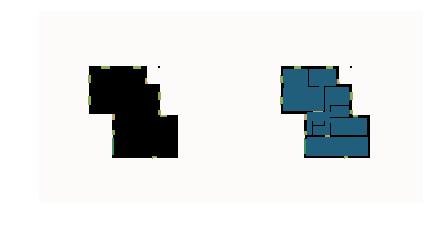

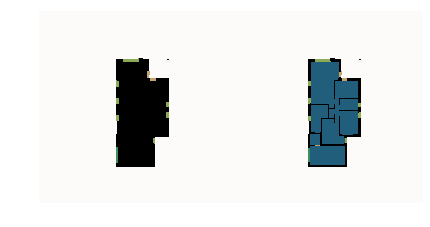

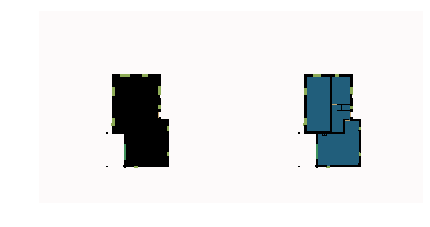

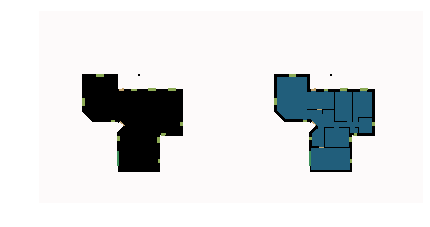

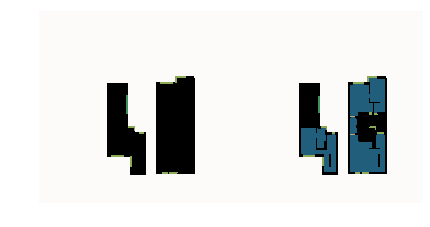

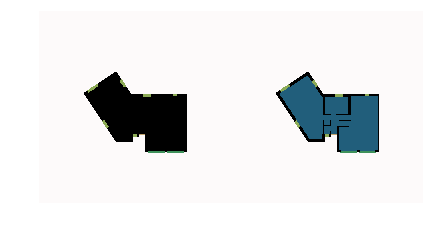

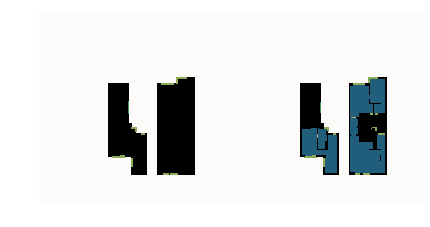

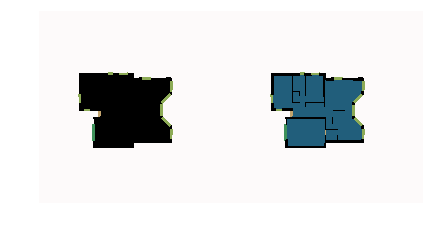

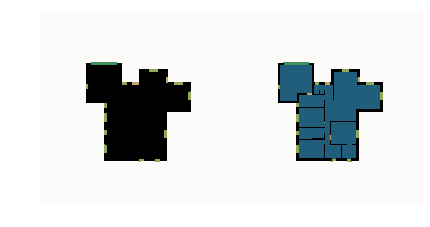

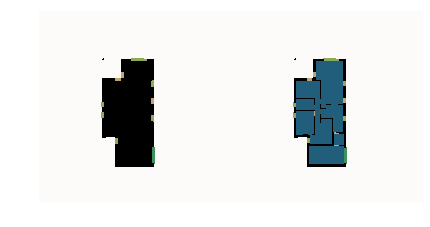

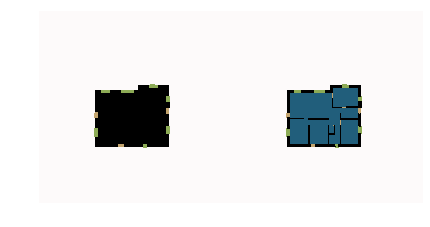

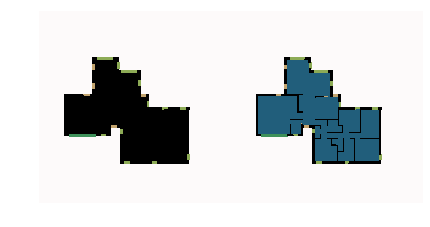

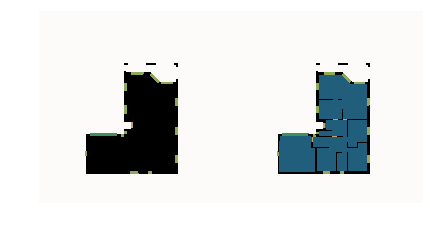

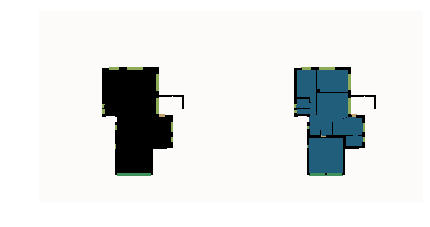

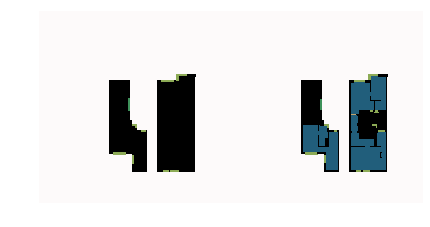

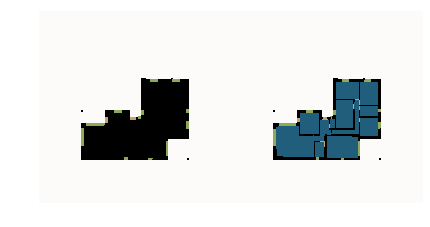

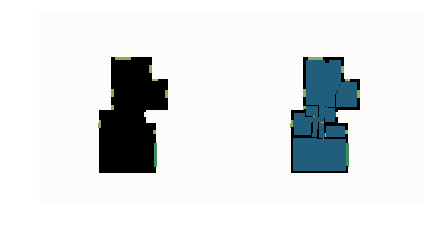

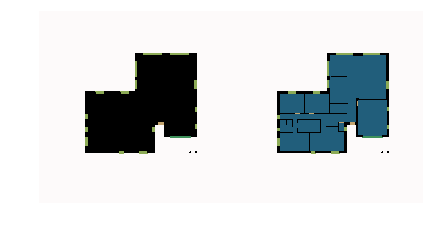

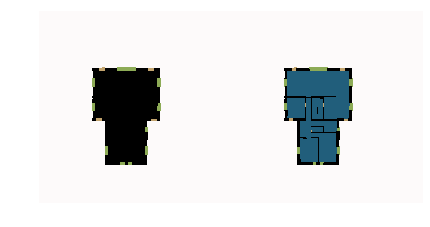

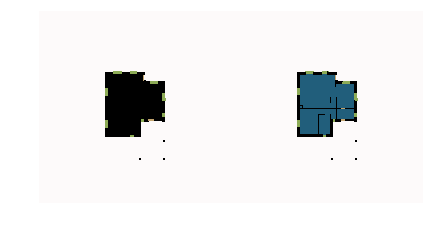

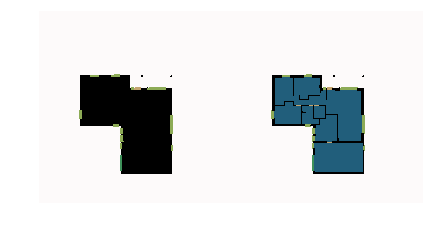

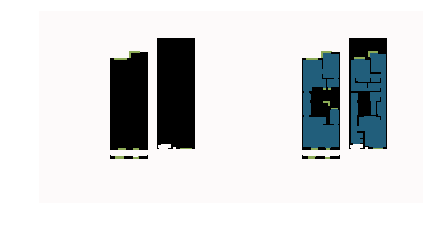

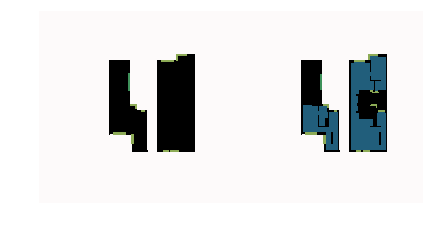

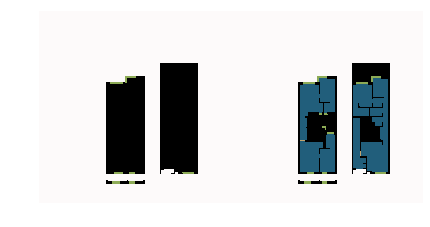

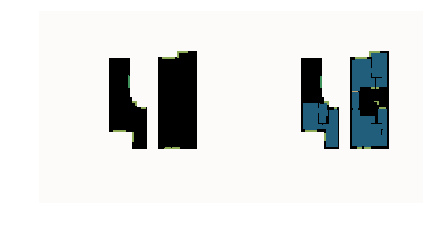

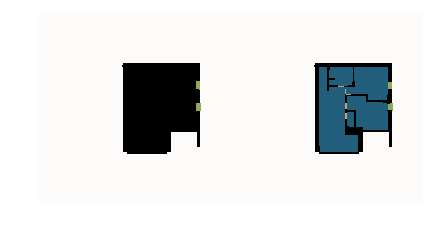

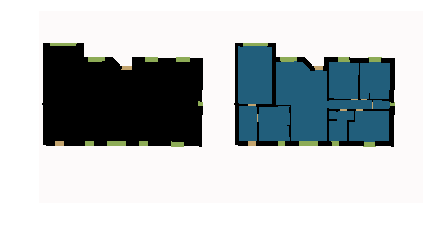

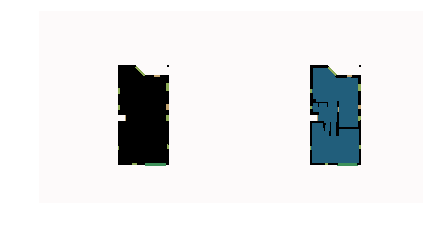

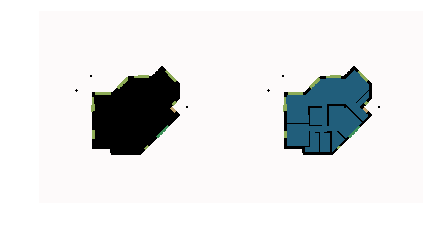

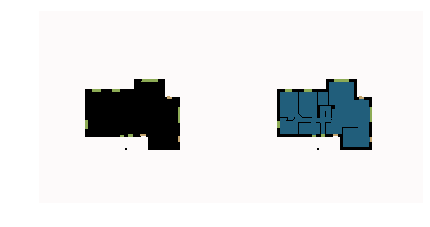

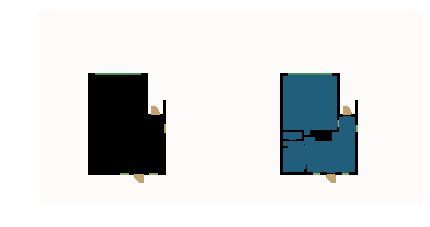

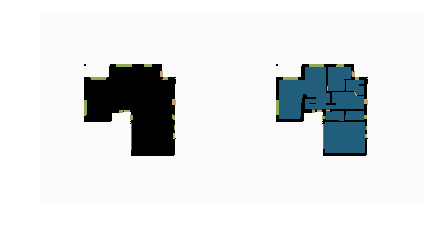

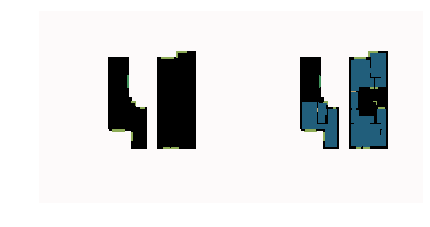

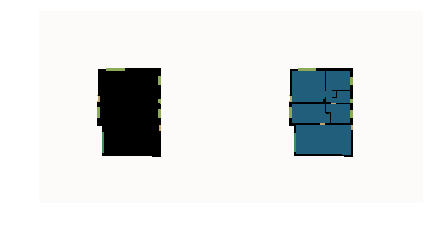

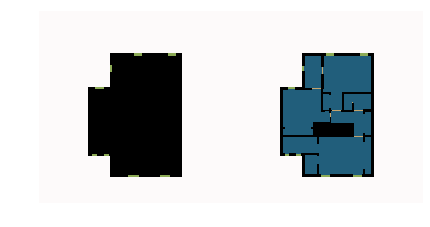

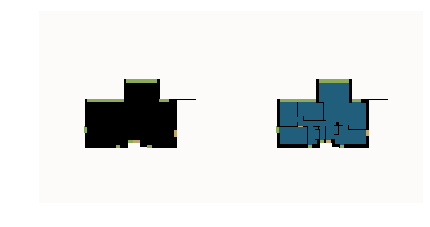

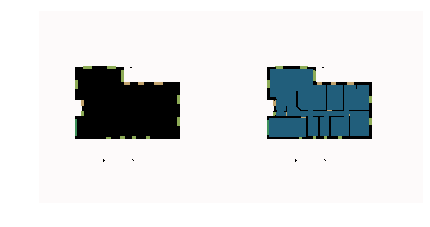

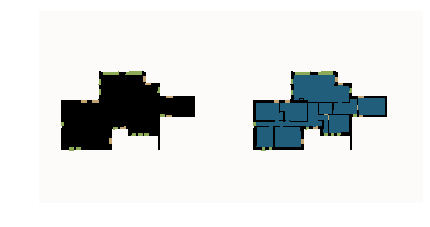

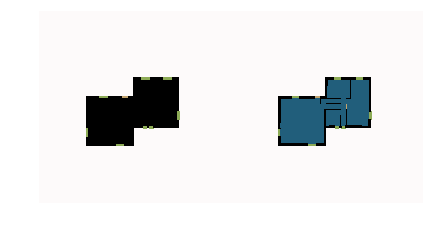

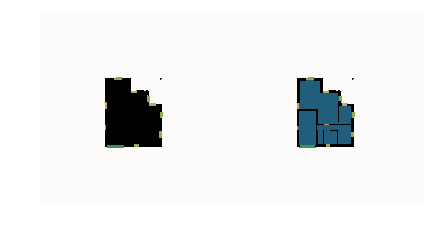

In [13]:
svgs = glob.glob('ImagesGT/*.svg')
for svg in tqdm(svgs[75:], position=0):
    save_sample(svg)

In [ ]:
svgs = glob.glob('ImagesGT/*.svg')

svg = svgs[0]

classes = (
    'Door',
    'Window',
    'Room',
    'Wall',
    'Separation',
    'Parking',
)

leftlineup = (
    ('Door', 1),
    ('Window', 2),
    ('Parking', 3),
    ('Room', 5),
    #('Door', 64),
    #('Window', 128),
    #('Parking', 196),
    #('Room', 255),
)

rightlineup = (
    ('Door', 1),
    ('Window', 2),
    ('Parking', 3),
    ('Room', 4),
    ('Wall', 5),
    #('Door', 64),
    #('Window', 128),
    #('Parking', 196),
    #('Room', 255),
    #('Wall', 32),
)

byclass, height, width = parse_svg(svg, classes)

mask = get_mask(byclass, height, width)
mask = (mask * (5 / 255)).astype(int)

left  = get_layer(mask, byclass, height, width, leftlineup, True)
right = get_layer(mask, byclass, height, width, rightlineup, False)

In [ ]:
#left, right = layers

cmaps = '''Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, 
Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, 
PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, 
Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, 
YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, 
binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, 
coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, 
gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, 
gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, 
inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, 
tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, 
twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r'''.replace('\n', '').split(', ')

print('cmaps', len(cmaps))

path = './tmp/{}.png'
for cmap in cmaps[-80:-60]:
    if not cmap.strip():
        continue
    f, (left_ax, right_ax) = plot(1, 2, figsize=(16, 16))
    f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    left_ax.axis('off')
    right_ax.axis('off')
    left_ax.imshow(left, cmap=cmap, vmin=0, vmax=None)
    right_ax.imshow(right, cmap=cmap, vmin=0, vmax=None)
    f.savefig(path.format(cmap))
    del f

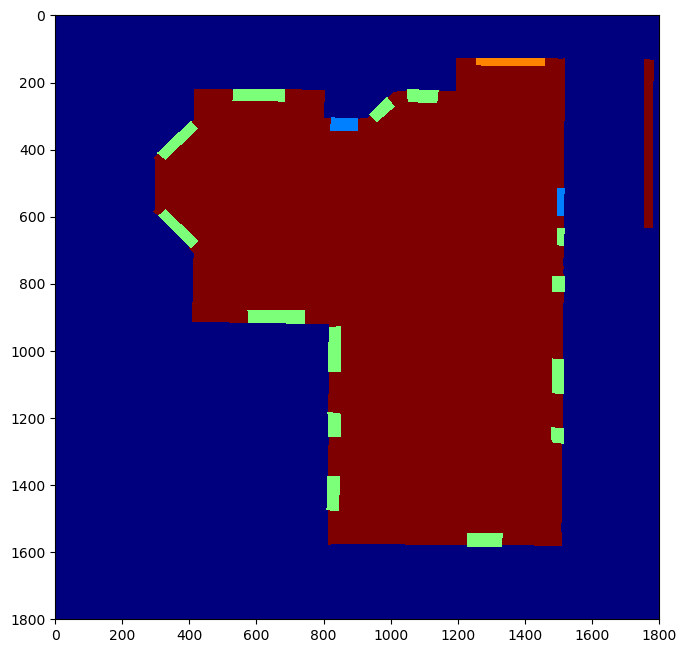

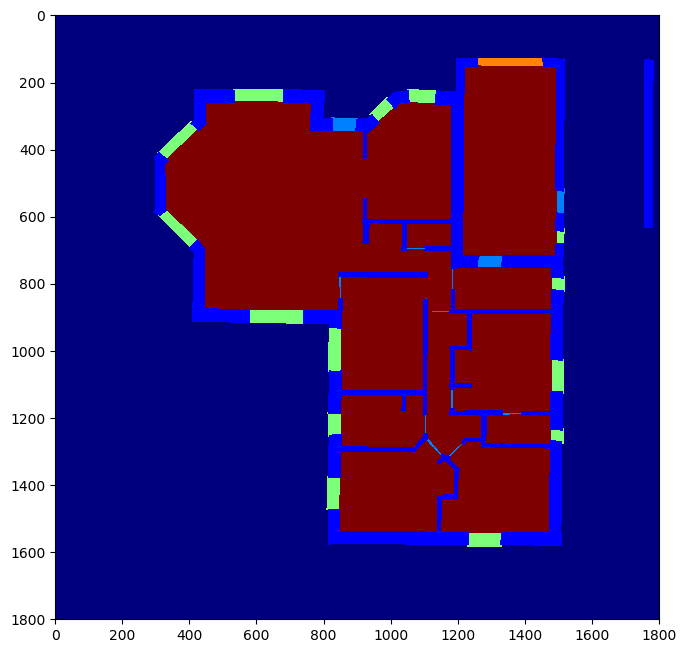

In [265]:
for layer in layers:
    f, ax = plot()
    ax.imshow(layer, cmap='jet', vmin=0, vmax=255)

In [166]:
#mask[:len(mask) // 2, :] += 128
"""
ValueError: Colormap gist_coolwarm is not recognized. Possible values are: 
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, 
Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, 
PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, 
Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, 
YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, 
binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, 
coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, 
gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, 
gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, 
inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, 
tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, 
twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r
"""

SVG cubicasa5k/high_quality/5714/model.svg


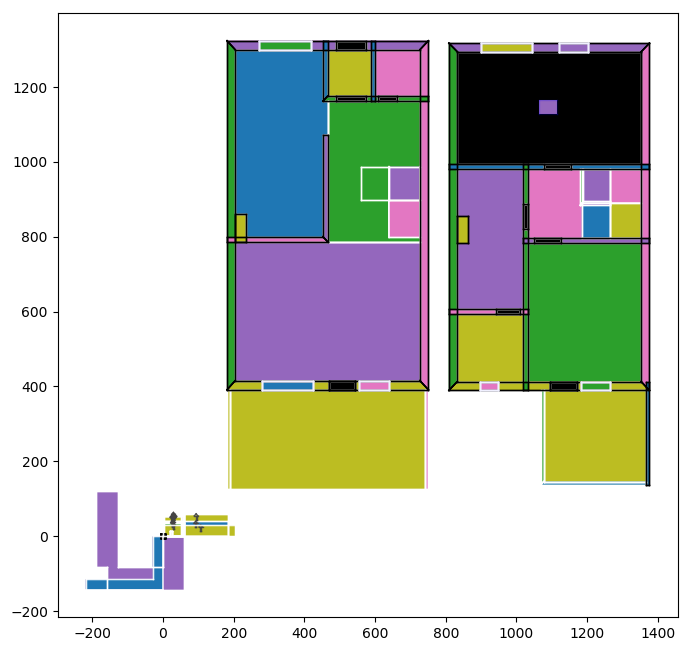

In [12]:
import reportlab


def py2loop(py):
    xs, ys = py.points[::2], py.points[1::2]
    loop = [vec3(x, y, 0) for x, y in zip(xs, ys)]
    #if loop_normal(loop).z < 0:
    #    loop.reverse()
    return loop


def show(polygons):
    f, ax = plot()
    for col, pys in polygons:
        for py in pys:
            loop = py2loop(py)
            plot_loop(ax, loop, lw=1, col=col, fill=col)


def comb(contents, polygons=None):
    polygons = defaultdict(list) if polygons is None else polygons
    for content in contents:
        #print(content.__dict__)
        if isinstance(content, reportlab.graphics.shapes.Group):
            comb(content.contents, polygons=polygons)
        elif isinstance(content, reportlab.graphics.shapes.Polygon):
            if content.fillColor:
                #color = content.fillColor.bitmap_rgb()
                color = content.fillColor.rgba()
            else:
                color = 'k'
            polygons[color].append(content)
        elif hasattr(content, 'points'):
            #print(content.__class__)
            continue
            if content.fillColor:
                color = content.fillColor.bitmap_rgb()
            else:
                color = 'k'
            polygons[color].append(content)
        else:
            #print('who dis', content)
            pass
    return list(polygons.items())


svgs = glob.glob('cubicasa5k/high_quality/*/model.svg')
svg = svgs[1]
print('SVG', svg)

drawing = svg2rlg(svg)
polygons = comb(drawing.contents)
show(polygons)